# Download public tracking data from Movebank

In [1]:
%matplotlib inline

import requests
from io import StringIO
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')
from bs4 import BeautifulSoup
import re

## Use DataCite to get a list of public Movebank datasets

There isn't a convenient way to query the [Movebank data repository](https://www.datarepository.movebank.org/), but all its datasets have a DOI registered with DataCite. DataCite does have a [tool to search for datasets](https://search.datacite.org/ui), so we query that API for Movebank datasets. This can be done in two ways:

1. Search for `contributor: "Movebank Data Repository"`. A few Movebank datasets on DataCite however don't have this field populated (e.g. http://data.datacite.org/10.5441/001/0000003) or don't have metadata at all (e.g. http://data.datacite.org/10.5441/001/1.5337CD16), so would miss those.
2. Search for DOI `prefix: "10.5441"`, which would also target datasets without metadata. That prefix however is shared between two publishers (`University of Konstanz` & `OpenProceedings.org`). The `Openproceedings.org` is managed by the University of Konstanz, but is not related to Movebank, so we would have to remove those.

We'll use the second approach.

### 1. Get datasets

In [2]:
parameters = {
    'q': '*',
    'fq': 'prefix:"10.5441"',
    'fl': ','.join([ # Fields to include
        'doi',
        'publisher',
        'contributor',
        'title',
        'description',
        'creator',
        'subject',
        'rightsURI',
        'publicationYear',
        'format',
        'descriptionType',
        'relatedIdentifier',
        'created',
        'updated']),
    'rows': 1000,
    'wt': 'csv'
}
results = requests.get('https://search.datacite.org/api', params=parameters)
results.url

'https://search.datacite.org/api?wt=csv&fl=doi%2Cpublisher%2Ccontributor%2Ctitle%2Cdescription%2Ccreator%2Csubject%2CrightsURI%2CpublicationYear%2Cformat%2CdescriptionType%2CrelatedIdentifier%2Ccreated%2Cupdated&q=%2A&fq=prefix%3A%2210.5441%22&rows=1000'

In [3]:
datasets = pd.read_csv(
    StringIO(results.text), # StringIO allows to read a variable as a file
    delimiter=',',
    dtype=object
)

### 2. Correct some formatting issues & remove OpenProceedings.org datasets

In the DataCite CSV response, commas are escaped within a field: `Tarroux A\, Weimerskirch H\, Wang\, S-H\, Brom...`, so we remove those to get: `Tarroux A, Weimerskirch H, Wang, S-H, Brom...`

In [4]:
datasets.replace(to_replace={r'\\,': ','}, regex=True, inplace=True)
# r'' indicates a raw string, here with a single escaped \ and comma
# regex=True, otherwise only whole field values are matched
datasets.head()

,doi,publisher,contributor,title,description,creator,subject,rightsURI,publicationYear,format,descriptionType,relatedIdentifier,created,updated
0,10.5441/001/1.TC76G560,University of Konstanz,Movebank Data Repository,"Data from: Olfaction and topography, but not m...","Pollonara E, Luschi P, Guilford T, Wikelski M,...","Pollonara, Enrica,Luschi, Paolo,Guilford, Tim,...","animal tracking,Argos,Calonectris diomedea,mag...",http://creativecommons.org/publicdomain/zero/1.0/,2015,csv,"Other,Abstract","HasPart:DOI:10.5441/001/1.tc76g560/1,HasPart:D...",2015-10-27T19:25:24Z,2015-10-27T19:25:25Z
1,10.5441/001/1.TC76G560/1,University of Konstanz,Movebank Data Repository,Navigation in Scopoli's shearwaters (data from...,"Pollonara E, Luschi P, Guilford T, Wikelski M,...","Pollonara, Enrica,Luschi, Paolo,Guilford, Tim,...","animal tracking,Argos,Calonectris diomedea,mag...",http://creativecommons.org/publicdomain/zero/1.0/,2015,csv,"Other,Abstract","IsPartOf:DOI:10.5441/001/1.tc76g560,IsSuppleme...",2015-10-27T19:25:26Z,2015-10-27T19:25:27Z
2,10.5441/001/1.TC76G560/2,University of Konstanz,Movebank Data Repository,Navigation in Scopoli's shearwaters (data from...,"Pollonara E, Luschi P, Guilford T, Wikelski M,...","Pollonara, Enrica,Luschi, Paolo,Guilford, Tim,...","animal tracking,Argos,Calonectris diomedea,mag...",http://creativecommons.org/publicdomain/zero/1.0/,2015,csv,"Other,Abstract","IsPartOf:DOI:10.5441/001/1.tc76g560,IsSuppleme...",2015-10-27T19:25:28Z,2015-10-27T19:25:29Z
3,10.5441/001/1.TC76G560/3,University of Konstanz,Movebank Data Repository,Navigation in Scopoli's shearwaters (data from...,"Pollonara E, Luschi P, Guilford T, Wikelski M,...","Pollonara, Enrica,Luschi, Paolo,Guilford, Tim,...","animal tracking,Argos,Calonectris diomedea,mag...",http://creativecommons.org/publicdomain/zero/1.0/,2015,csv,"Other,Abstract","IsPartOf:DOI:10.5441/001/1.tc76g560,IsSuppleme...",2015-10-27T19:25:30Z,2015-10-27T19:25:30Z
4,10.5441/001/1.33159H1H,University of Konstanz,Movebank Data Repository,Data from: Temporal and contextual consistency...,"Santos CD, Neupert S, Lipp H-P, Wikelski M, De...","Santos, Carlos David,Neupert, Stefanie,Lipp, H...","animal movement,animal navigation,collective m...",http://creativecommons.org/publicdomain/zero/1.0/,2014,csv,"Other,Abstract","HasPart:DOI:10.5441/001/1.33159h1h/1,HasPart:D...",2014-07-31T16:56:08Z,2014-07-31T16:56:09Z


In [5]:
datasets = datasets[datasets['publisher'] != 'OpenProceedings.org'] # Exclude OpenProceedings.org datasets

### 3. Save list of datasets as a csv file

In [6]:
datasets.to_csv('../data/datasets.csv', index=False)

### 4. Get some basic statistics

In [7]:
datasets.count()['doi']

220

In [8]:
datasets.columns.tolist()

['doi',
 'publisher',
 'contributor',
 'title',
 'description',
 'creator',
 'subject',
 'rightsURI',
 'publicationYear',
 'format',
 'descriptionType',
 'relatedIdentifier',
 'created',
 'updated']

In [9]:
field_of_interest = 'publicationYear'

In [10]:
field_of_interest_groupby = datasets.groupby([field_of_interest]).count()['doi'].reset_index()

In [11]:
field_of_interest_groupby

,publicationYear,doi
0,2008,1
1,2009,2
2,2011,5
3,2012,15
4,2013,19
5,2014,41
6,2015,86
7,2016,41


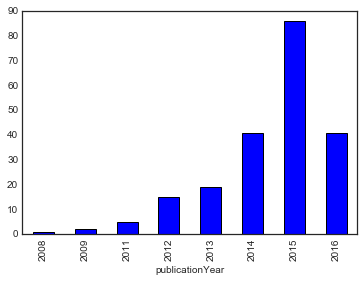

In [12]:
field_of_interest_groupby.plot(kind='bar', x=field_of_interest, legend=False)